# ECS7020P mini-project submission

The mini-project has two separate components:


1.   **Basic component** [6 marks]: Using the MLEnd London Sounds dataset, build a machine learning pipeline that takes as an input an audio segment and predicts whether the audio segment has been recorded indoors or outdoors.
2.   **Advanced component** [10 marks]: Formulate your own machine learning problem and build a machine learning solution using the MLEnd London Sounds dataset. 

Your submission will consist of two Jupyter notebooks, one for the basic component and another one for advanced component. Please **name each notebook**:

* ECS7020P_miniproject_basic.ipynb
* ECS7020P_miniproject_advanced.ipynb

then **zip and submit them toghether**.

Each uploaded notebook should include: 

*   **Text cells**, describing concisely each step and results.
*   **Code cells**, implementing each step.
*   **Output cells**, i.e. the output from each code cell.

and **should have the structure** indicated below. Notebooks might not be run, please make sure that the output cells are saved.

How will we evaluate your submission?

*   Conciseness in your writing (10%).
*   Correctness in your methodology (30%).
*   Correctness in your analysis and conclusions (30%).
*   Completeness (10%).
*   Originality (10%).
*   Efforts to try something new (10%).

Suggestion: Why don't you use **GitHub** to manage your project? GitHub can be used as a presentation card that showcases what you have done and gives evidence of your data science skills, knowledge and experience. 

Each notebook should be structured into the following 9 sections:


# 1 Author

**Student Name**: Karan Kaushik
**Student ID**: 220706816

# 2 Problem formulation

In this project we're using a set of sounds along with some meta data and trying to identify whether the sounds were recorded indoors or outdoors.  
Since the data was recorded using various different devices and during different times of the day, it will be a challenging task to isolate features that can be used for the classification task in a reliable way.

# 3 Machine Learning pipeline

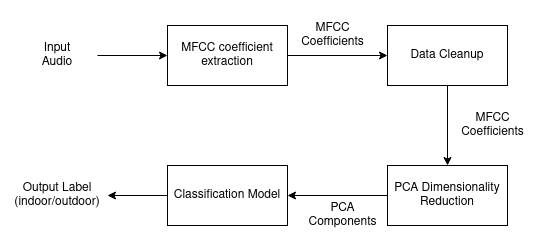

# 4 Transformation stage

#### MFCC for feature extraction
Mel Frequency Cepstral Coefficients is used to extract information about the frequency spectrum of the audio file in each frame of the audio file.
#### PCA for dimensionality reduction
Principle Component Analysis is used to reduce the dimensionality of the MFCC components from time series data to just 5 components which can further be fed into an ML model to be trained.

# 5 Modelling

We'll use the following models to classify our data set and compare the results  
1. Support Vector Machines
    - SVM 
2. Random Forest Classifier 
    - RFC is an ensemble classifier i.e. it consists of multiple sub-classifiers and the output is a combination of the result of these sub-classifiers. Since the PCA dataset 

# 6 Methodology

In order to validate the model that we've built in the previous stage we split the dataset into training and testing subsets. We use the training dataset to create model 

# 7 Dataset

The dataset consists of 2500 audio recordings of ambient sounds at various spots in London along with the phrase "this is London" spoken by the person recording the sounds. Further, dataset consists of meta data about the recording
1. Audio files 
1. Meta data
    1. Area of recording
    1. Spot (location) inside the area
    1. Location type (inside / outside)
    1. Participant ID

In [4]:
import os, sys, re, pickle, glob
import pandas as pd
import IPython.display as ipd

display(ipd.Audio(files[5]))
display(ipd.Audio(files[6]))
    
sample_path = 'MLEndLS/*.wav'
files = glob.glob(sample_path)
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 
display(MLENDLS_df.head())

,area,spot,in_out,Participant
file_id,,,,
0001.wav,british,street,outdoor,S151
0002.wav,kensington,dinosaur,indoor,S127
0003.wav,campus,square,outdoor,S18
0004.wav,kensington,hintze,indoor,S179
0005.wav,campus,square,outdoor,S176


# 8 Results

Carry out your experiments here, explain your results.

In [187]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import math

import urllib.request
import zipfile

from tqdm import tqdm
import librosa
import scipy.stats as stats

In [56]:
sample_path = 'MLEndLS/*.wav'
files = glob.glob(sample_path)
MLENDLS_df = pd.read_csv('./MLEndLS.csv').set_index('file_id') 

In [280]:
aud_data = []
labels = []

for n in range(0,len(files)):
    a, fs = librosa.load(files[n],sr=None)    
    
    # MFCC Feature extraction
    d_mfcc = librosa.feature.mfcc(y=a, sr=fs)
    d_mfcc = librosa.power_to_db(d_mfcc, ref=np.max)
    
    # Trimming to get a standard input size
    d_mfcc = d_mfcc[:,:536].T
    d_mfcc = d_mfcc.reshape(1,d_mfcc.shape[0]*d_mfcc.shape[1])
    d_mfcc = d_mfcc[0]
    
    # Filtering errored/invalid data
    if len(d_mfcc) < 10720: continue
        
    if (n%100 == 0): print(n, end="\r")
        
    aud_data.append(d_mfcc)
    labels.append(MLENDLS_df.loc[files[n].split('/')[-1]].in_out)
    
print("\nDone")

2400
Done


In [281]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# After various attempts, it was observed that we get the best results with atleast 5 components
numComponents = 5
pca = PCA(n_components=numComponents)
pca.fit(aud_data)

projected = pca.transform(aud_data)
projected = pd.DataFrame(projected,columns=['pc1','pc2','pc3','pc4','pc5'],index=range(1,len(aud_data)+1))
display(projected)

,pc1,pc2,pc3,pc4,pc5
1,496.273688,-1627.158133,-663.147782,-642.597629,553.104122
2,-1427.422455,570.942963,338.524282,793.816415,-744.958247
3,148.189670,137.582675,-708.643630,1054.707158,650.125347
4,1299.744997,-186.685546,-455.963521,590.182121,431.021297
5,985.473985,-1217.602096,-243.111914,143.716085,90.001786
...,...,...,...,...,...
2475,578.036888,81.470392,505.227408,160.768467,-212.988273
2476,-852.497143,-279.227471,-792.559738,-528.714587,-72.543250
2477,1289.524839,245.191524,448.767694,-283.899274,25.959704
2478,467.655667,-60.914381,520.583015,470.970900,-254.453643


In [341]:
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_val, y_train, y_val = train_test_split(projected,labels,test_size=0.20)
print(X_train.shape, X_val.shape)

(1983, 5) (496, 5)


In [342]:
from sklearn import svm

parameters = {'C':[1,2,3,4,5]}

svc = svm.SVC()
clf_model = GridSearchCV(svc, parameters,cv=5)

clf_model.fit(X_train,y_train)

print('Hyperparameters: ', clf_model.best_estimator_)
print('Average accuracy: ', clf_model.best_score_)
print('Test dataset accuracy:', clf_model.score(X_val, y_val))

Hyperparameters:  SVC(C=1)
Average accuracy:  0.7402755514846195
Test dataset accuracy: 0.7540322580645161


In [349]:
parameters = {
    'n_estimators':[50,100,200], 
    'max_features':[1,2,5], 
    'max_depth':[5,10,20]
}

rfc = RandomForestClassifier()
clf_model = GridSearchCV(rfc, parameters,cv=2)

clf_model.fit(X_train,y_train)

print('Best Model Hyperparameters: ', clf_model.best_estimator_)
print('Best Model Accuracy: ', clf_model.best_score_)
print('Test Data Accuracy:', clf_model.score(X_val, y_val))

Best Model Hyperparameters:  RandomForestClassifier(max_depth=5, max_features=2)
Best Model Accuracy:  0.7191075526512809
Test Data Accuracy: 0.7379032258064516


------------------

# 9 Conclusions

Your conclusions, improvements, etc should go here